# Pancreas endocrinogenesis E1415 - Monge Velo

# Imports and settings

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import scvelo as scv

import cellrank as cr
from cellrank.kernels import VelocityKernel
from cellrank.estimators import GPCCA
from anndata import AnnData, concat

import cloudpickle
import jax.numpy as jnp

from moscot.problems.time import TemporalNeuralProblem

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [2]:
cr.logging.print_versions()

cellrank==1.5.1+g525b847 scanpy==1.9.1 anndata==0.8.0 numpy==1.23.5 numba==0.56.4 scipy==1.10.0 pandas==1.5.2 pygpcca==1.0.4 scikit-learn==1.2.0 statsmodels==0.13.5 scvelo==0.2.5 pygam==0.8.0 matplotlib==3.6.2 seaborn==0.12.2


# Data loading and preprocessing

In [3]:
adata145 = sc.read("/lustre/groups/ml01/workspace/monge_velo/data/benchmarks/pancreas/day_14.5_growth_rate.h5ad")
adata155 = sc.read("/lustre/groups/ml01/workspace/monge_velo/data/benchmarks/pancreas/day_15.5_growth_rate.h5ad")
adata_prep = concat([adata145, adata155], merge = 'same')

In [4]:
adata_prep

AnnData object with n_obs × n_vars = 20519 × 16206
    obs: 'day', 'n_counts', 'log_counts', 'n_genes', 'mt_frac', 'proliferation', 'G2M_score', 'S_score', 'clusters_fig3_final', 'clusters_fig3_final_noep', 'clusters_fig4_final', 'clusters_fig2_final', 'clusters_fig6_broad_final', 'clusters_fig6_fine_final', 'clusters_fig6_alpha_final', 'celltype', 'prolif', 'apoptosis', 'growth_rate', 'scaled_growth_rate', 'scaled3_growth_rate', 'scaled4_growth_rate'
    var: 'n_cells', 'highly_variable_genes', 'expression_mean', 'dispersion', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'spliced', 'unspliced'

# Computation temporal-neural-problem

In [ ]:
tnp = TemporalNeuralProblem(adata_prep)
tnp = tnp.score_genes_for_marginals("mouse", "mouse")
tnp = tnp.prepare("day", joint_attr="X_pca")
tnp = tnp.solve(tau_a=0.95, tau_b=0.95)

# Precomputed data

In [5]:
with open("/lustre/groups/ml01/workspace/monge_velo/data/benchmarks/pancreas/test_save_tnp", "rb") as f:
    tnp = cloudpickle.load(f)

# Performance plots: training

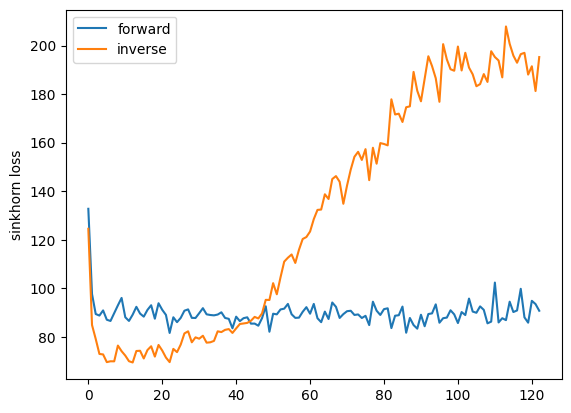

In [6]:
fig, ax = plt.subplots()
ax.plot(tnp[14.5, 15.5].solution._training_logs["valid_logs"]["sinkhorn_loss_forward"], label="forward")
ax.plot(tnp[14.5, 15.5].solution._training_logs["valid_logs"]["sinkhorn_loss_inverse"], label="inverse")
ax.set_ylabel("sinkhorn loss")
ax.legend()
plt.show()

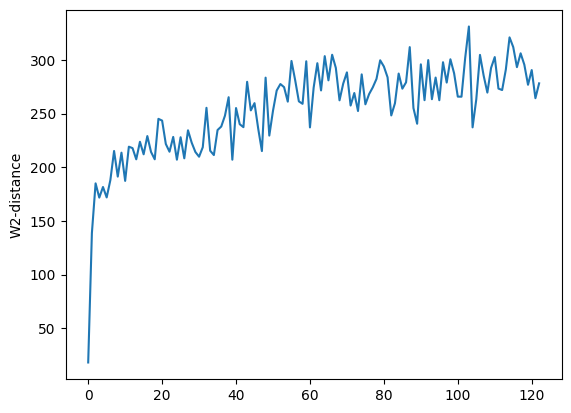

In [7]:
fig, ax = plt.subplots()
ax.plot(tnp[14.5, 15.5].solution._training_logs["valid_logs"]["valid_w_dist"])
ax.set_ylabel("W2-distance")
plt.show()

# Data preparation

In [6]:
source = jnp.array(adata_prep.obsm["X_pca"].copy())
velocity = tnp[14.5, 15.5].solution.push(source) - source

adata = AnnData(shape=velocity.shape)
adata.obs = adata_prep.obs.copy()

adata.layers['spliced'] = np.ones((20519, 50))
adata.layers['unspliced'] = np.ones((20519, 50))
adata.X = np.ones((20519,50))

adata.layers["GEX_velocity"] = np.asarray(velocity)
adata.layers["X_pca"] = np.asarray(adata_prep.obsm["X_pca"])

adata.obsm["X_pca"] = adata.layers["X_pca"].copy()
adata.layers["velocity"] = adata.layers["GEX_velocity"].copy()
sc.pp.neighbors(adata, use_rep="X_pca")
scv.pp.moments(adata)
scv.tl.umap(adata)

adata.obs['celltype'] = adata.obs['celltype'].astype('category')

Normalized count data: X, spliced, unspliced.
computing neighbors
    finished (0:00:05) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


# Transition probabilities

In [8]:
vk = VelocityKernel(adata, xkey="X_pca", vkey="GEX_velocity").compute_transition_matrix()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20519/20519 [00:04<00:00, 4883.93cell/s]


# Macrostate calculation

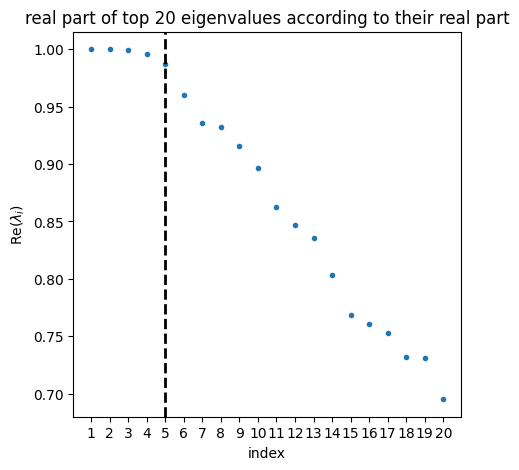

In [9]:
g = GPCCA(vk)
g.compute_schur(n_components=20)
g.plot_spectrum(real_only=True)

/home/icb/jonas.flor/miniconda3/envs/neuralBenchmark_moscot/lib/python3.9/site-packages/scvelo/plotting/scatter.py:614: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(


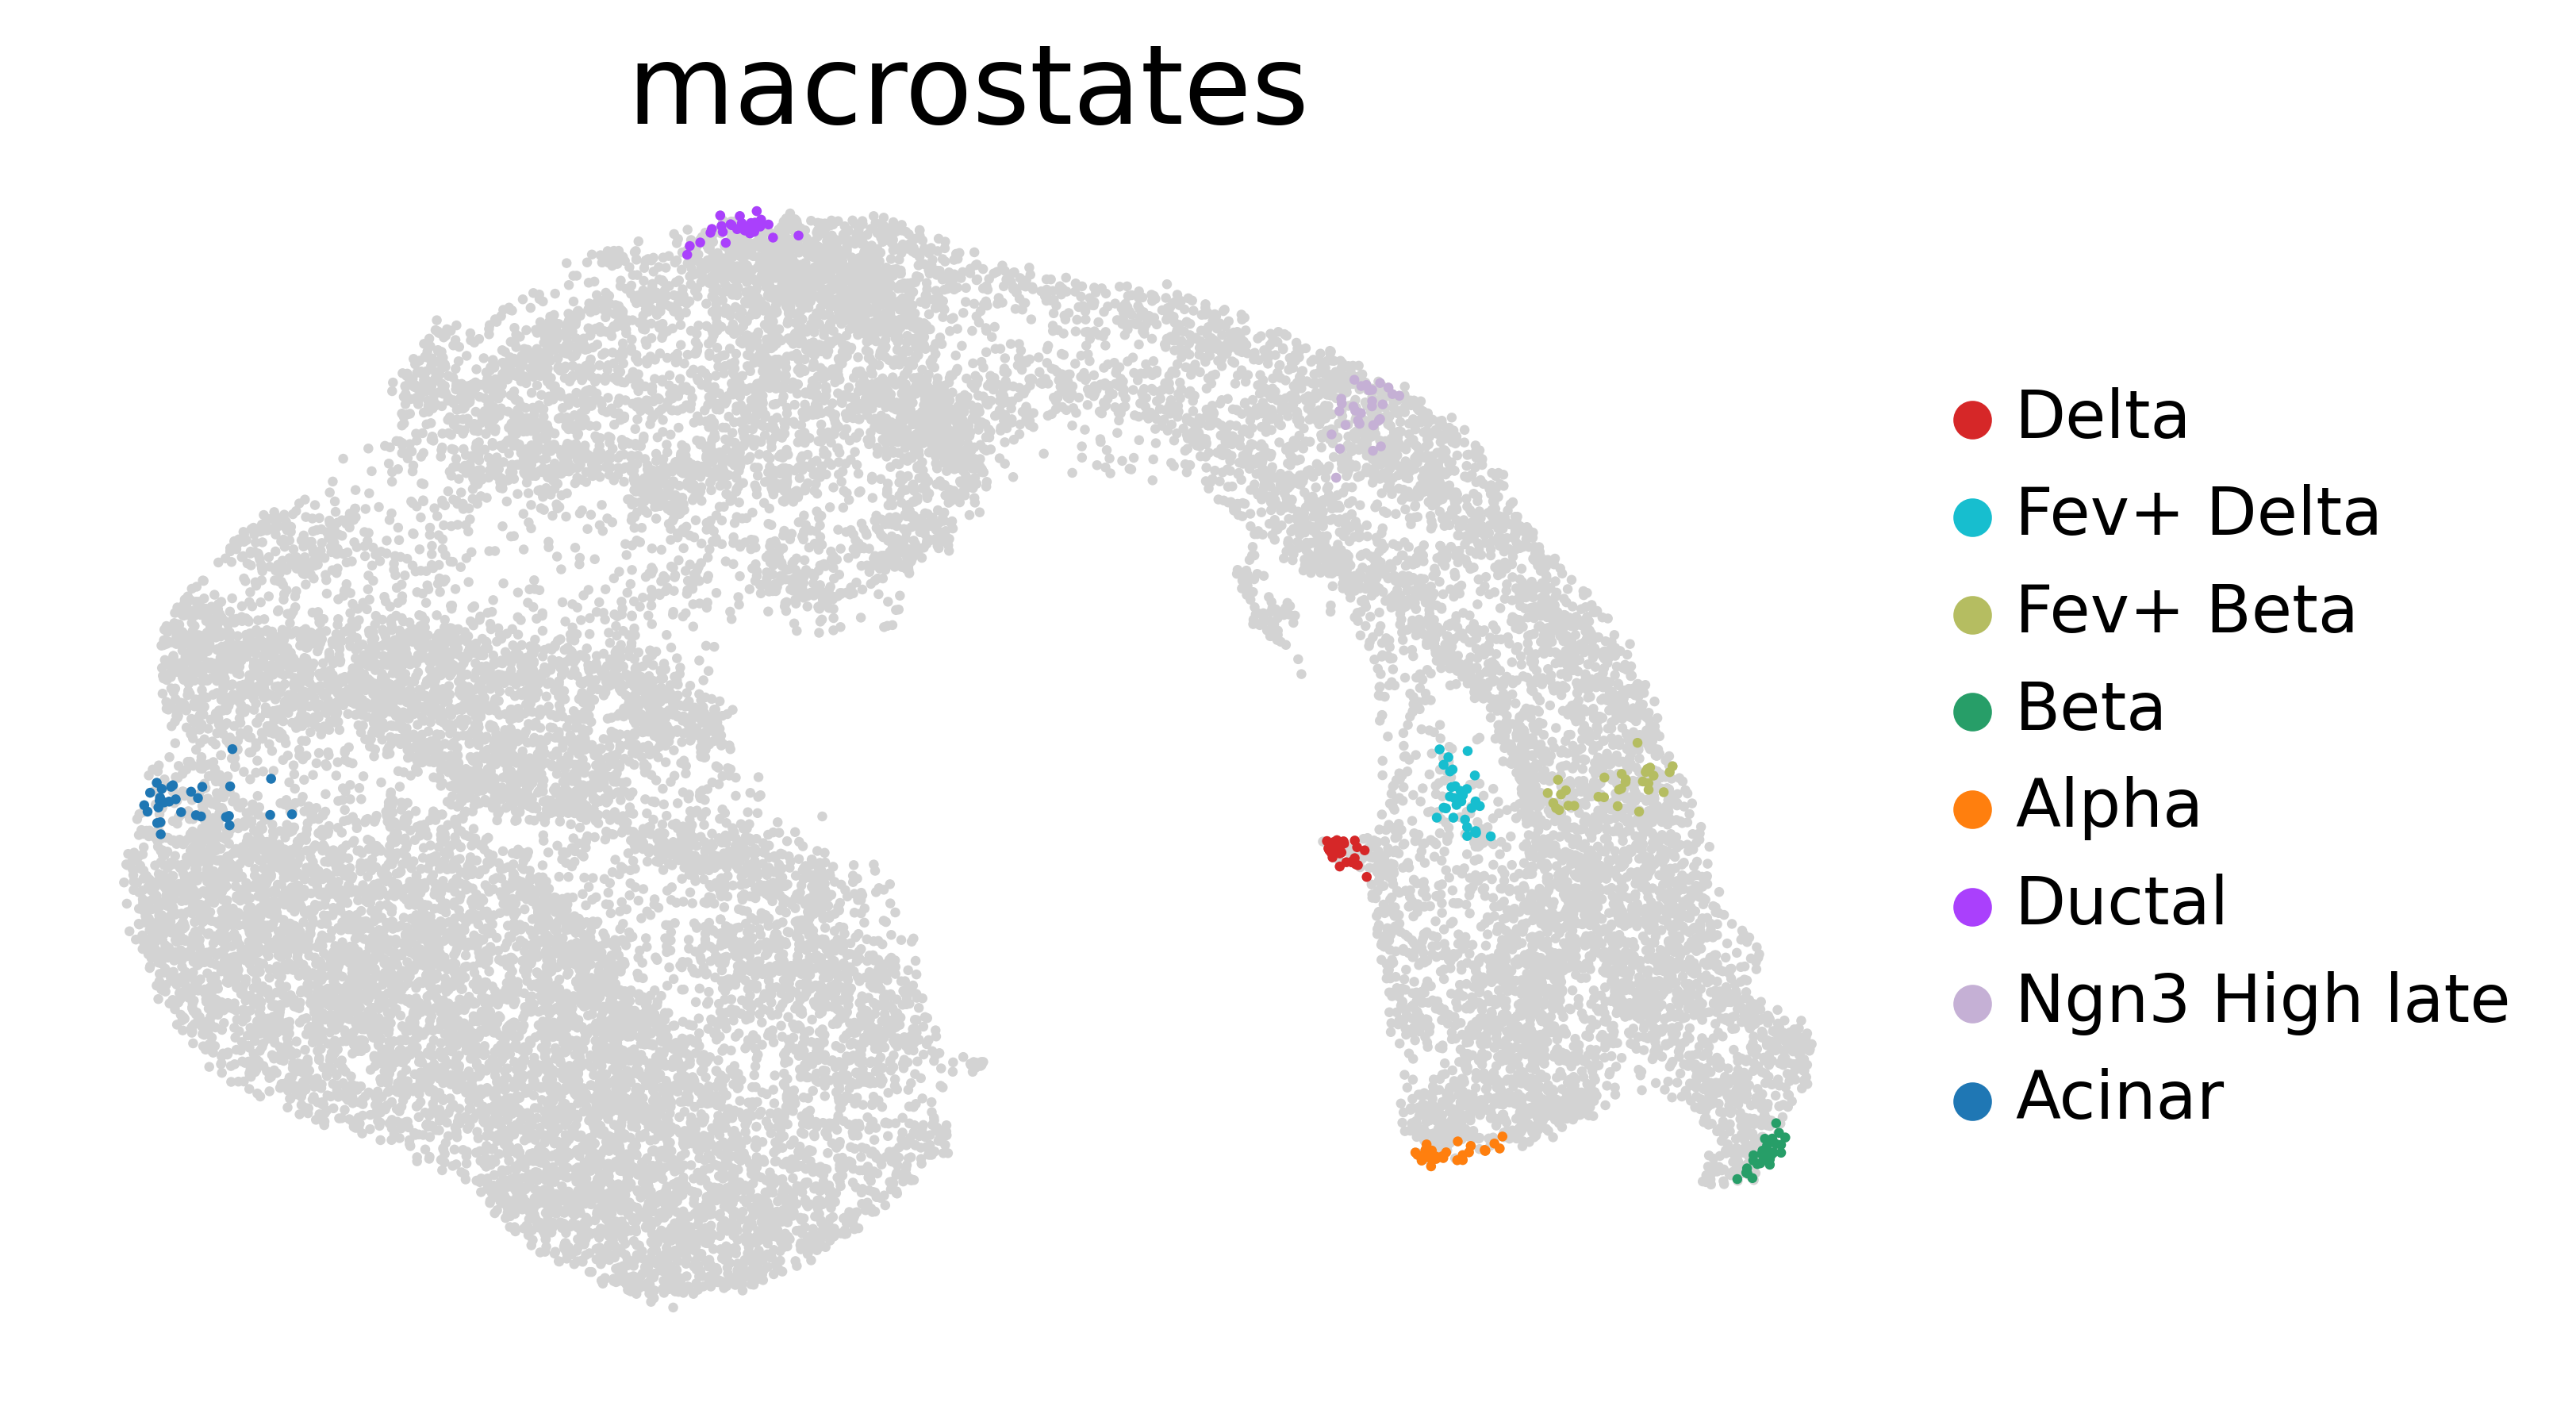

In [10]:
g.compute_macrostates(n_states=8, cluster_key="celltype")
scv.set_figure_params('scvelo', transparent=True, fontsize=20, color_map='viridis')
g.plot_macrostates(discrete=True, basis="umap", legend_loc="right", legend_fontweight='normal', legend_fontsize='12', dpi=250)

/home/icb/jonas.flor/miniconda3/envs/neuralBenchmark_moscot/lib/python3.9/site-packages/scvelo/plotting/scatter.py:614: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(


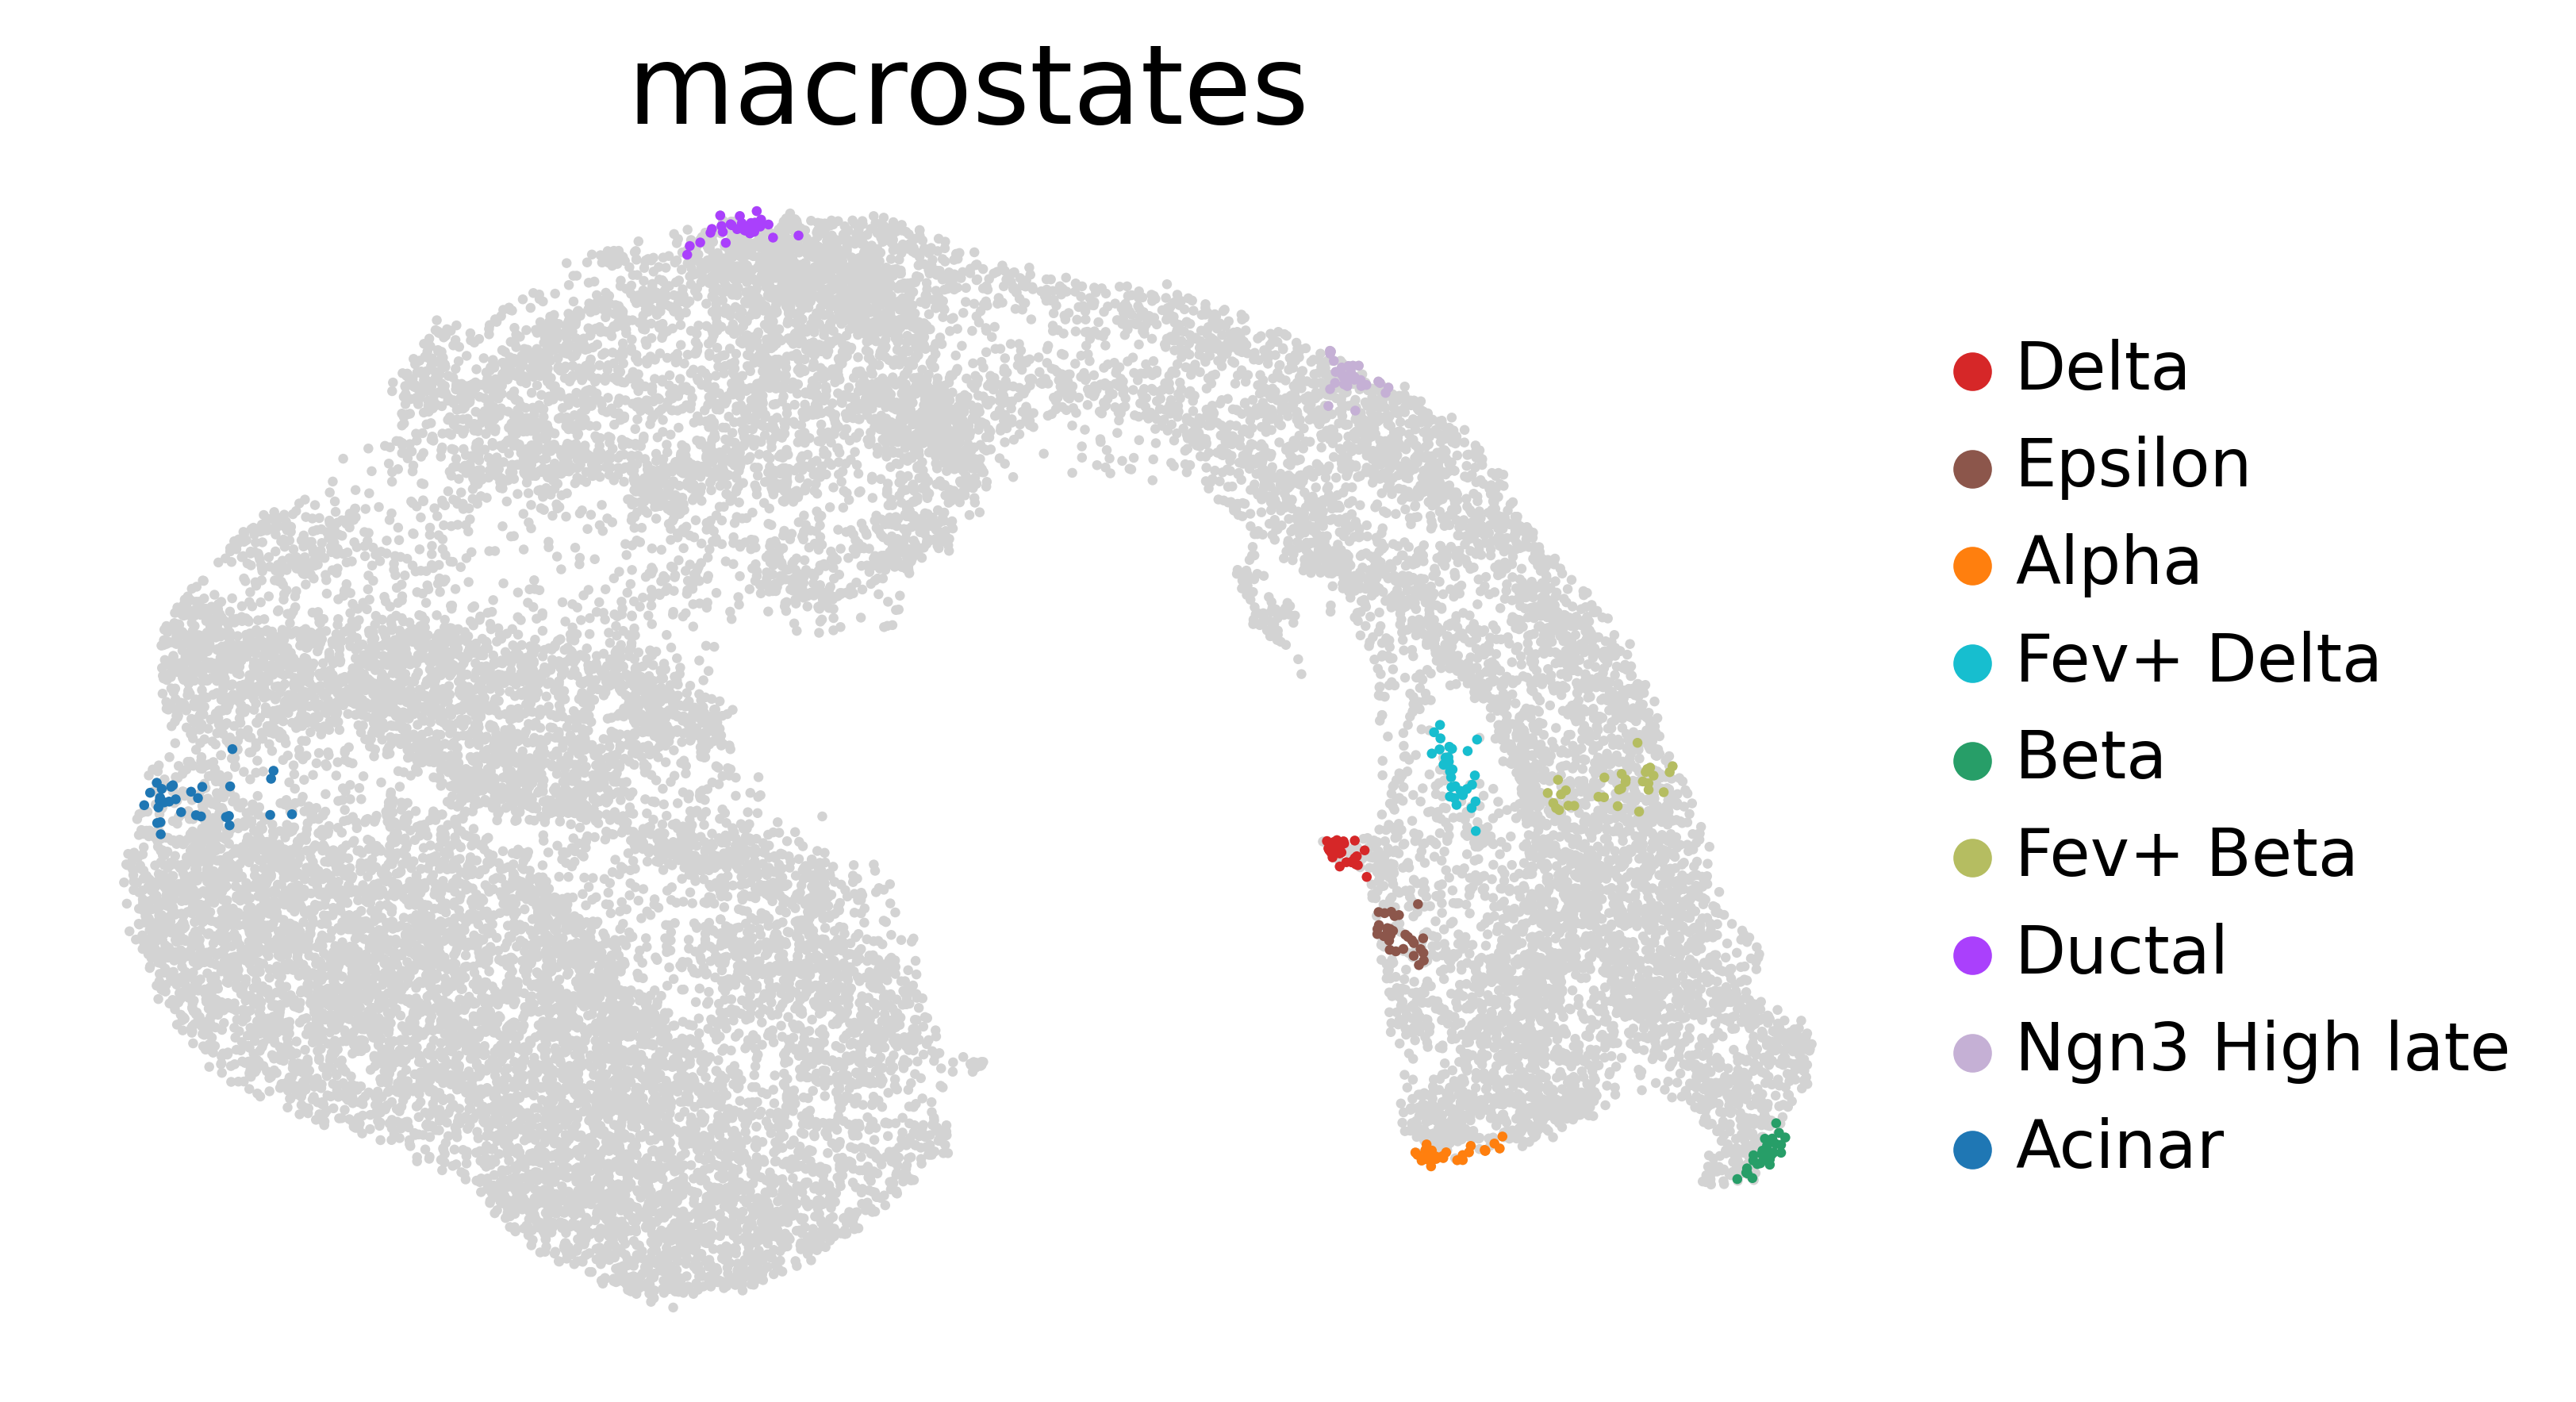

In [11]:
g.compute_macrostates(n_states=9, cluster_key="celltype")
scv.set_figure_params('scvelo', transparent=True, fontsize=20, color_map='viridis')
g.plot_macrostates(discrete=True, basis="umap", legend_loc="right", legend_fontweight='normal', legend_fontsize='12', dpi=250)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.02s/]
/home/icb/jonas.flor/miniconda3/envs/neuralBenchmark_moscot/lib/python3.9/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


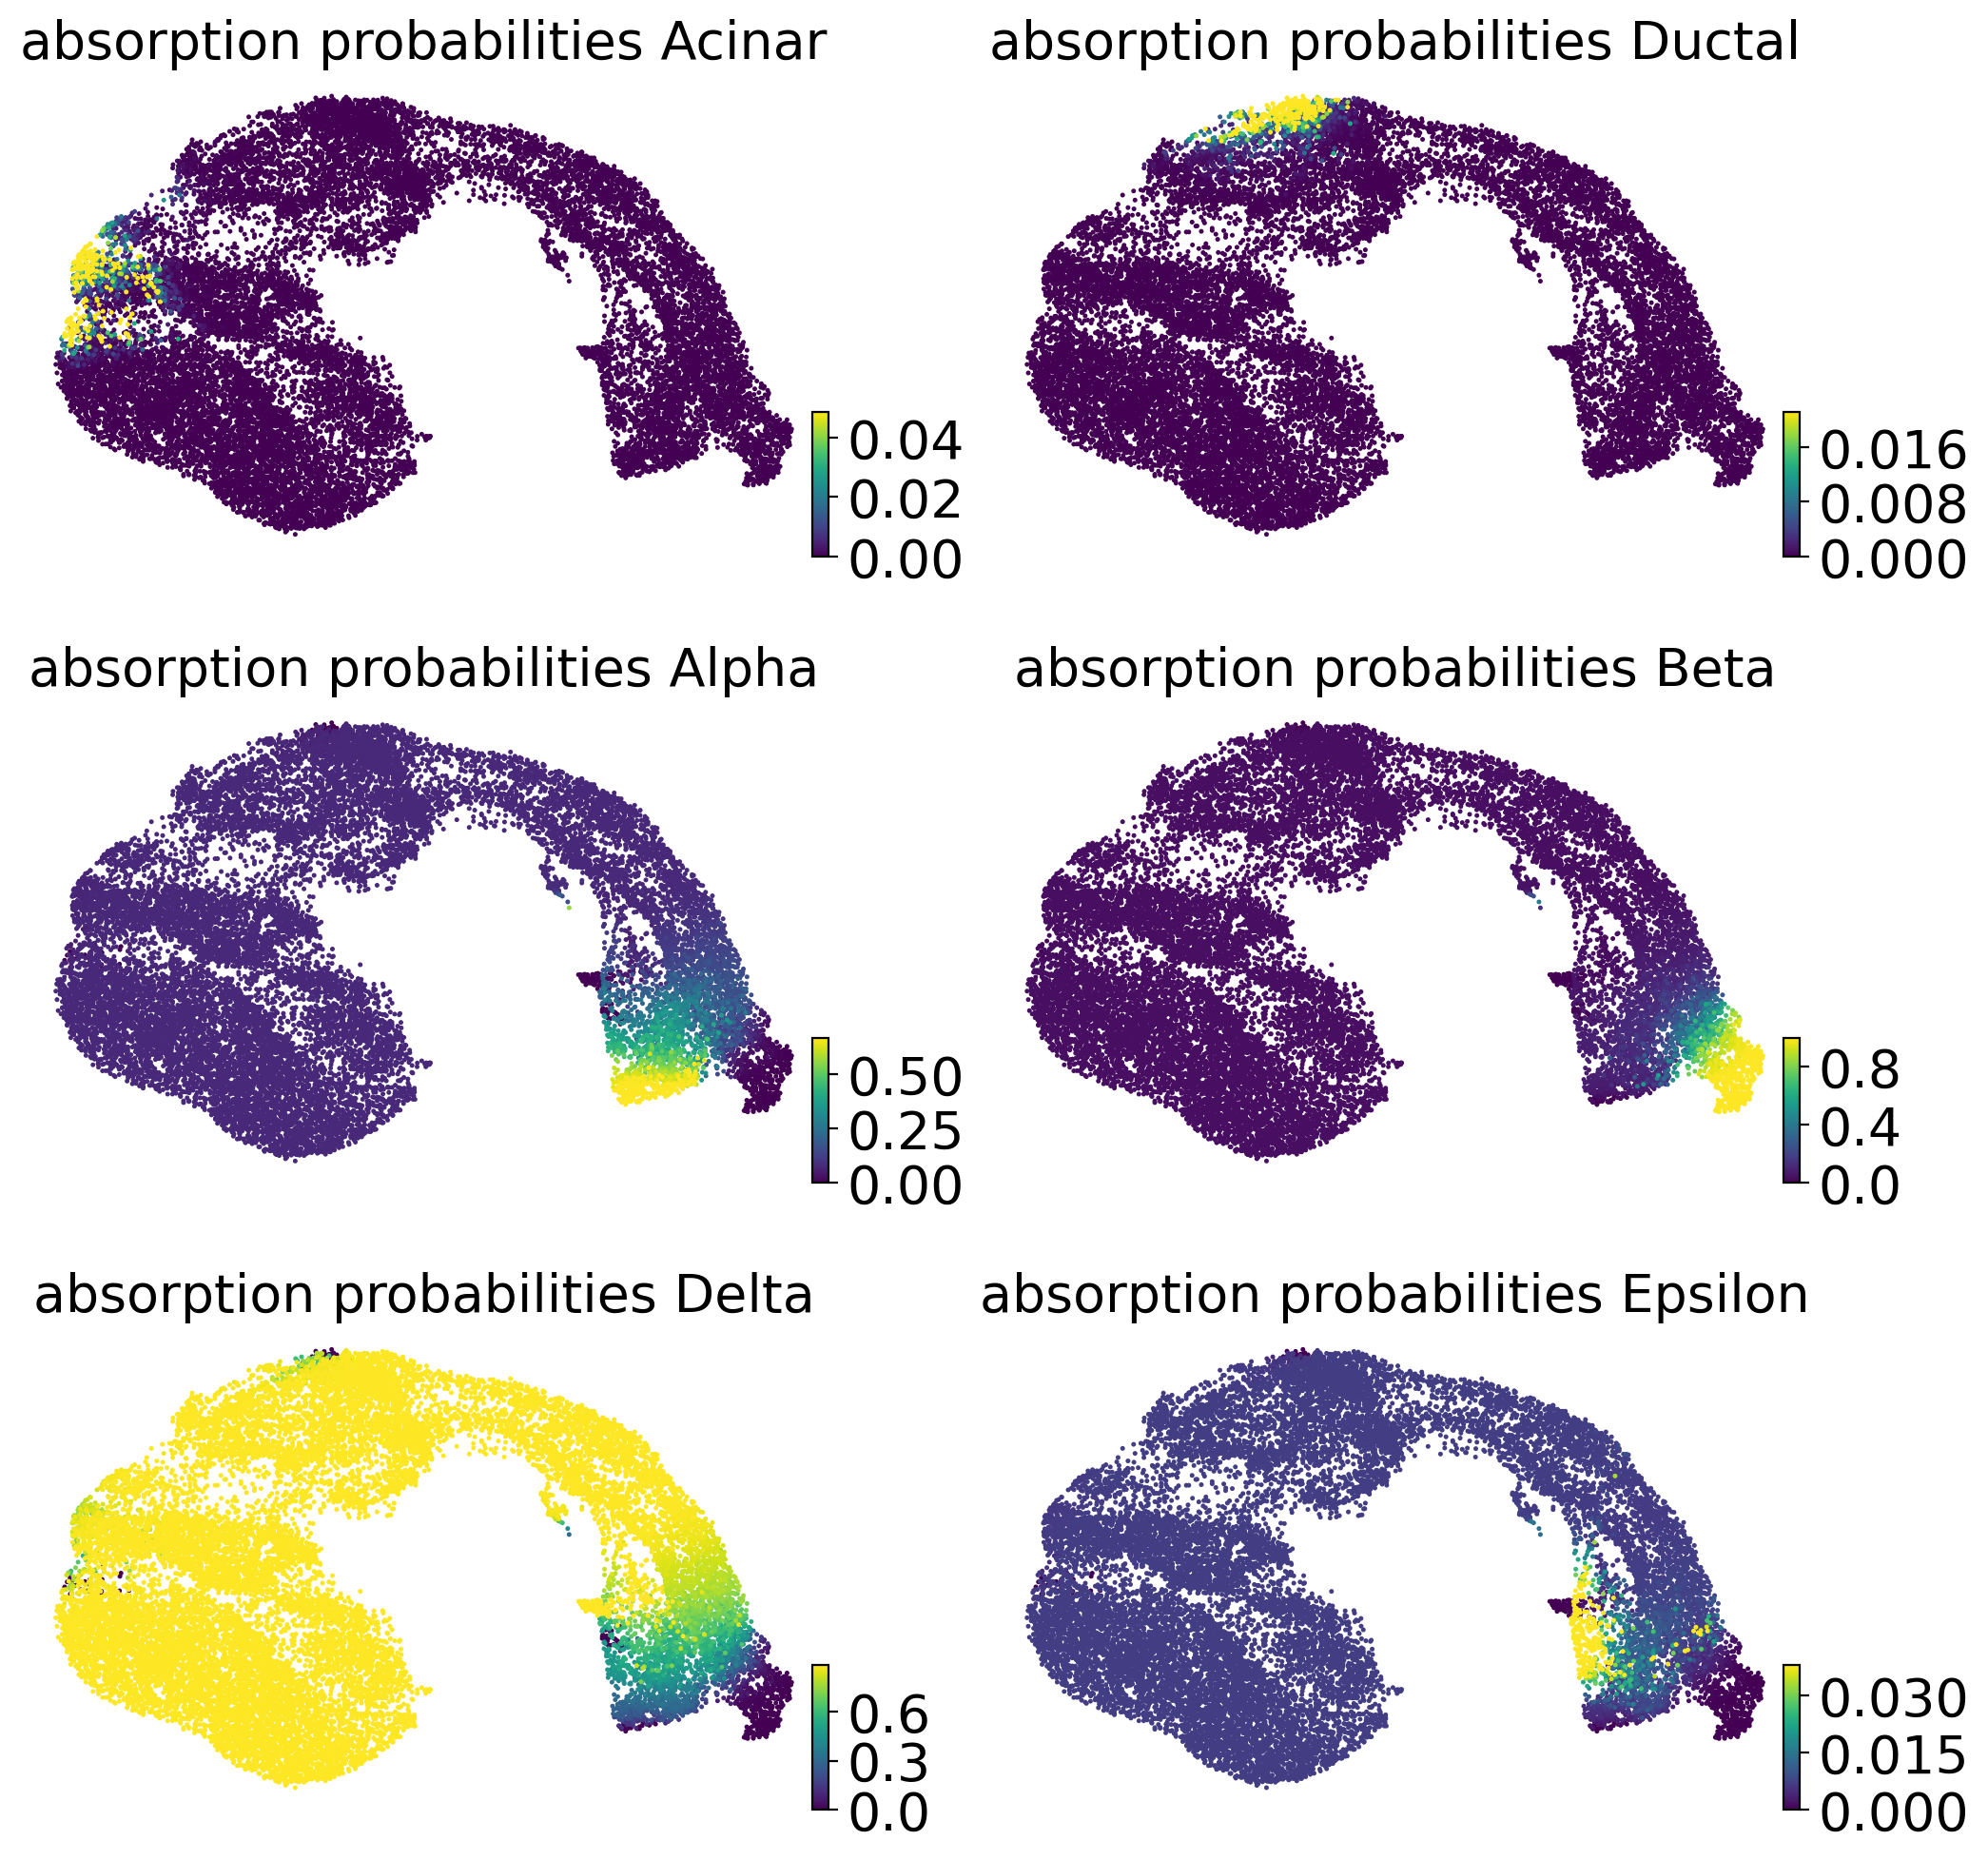

In [12]:
g.set_terminal_states_from_macrostates(
    [
        "Acinar", "Ductal", "Alpha", "Beta", "Delta", "Epsilon"
    ]
)
g.compute_absorption_probabilities(solver="gmres", use_petsc=True, tol=1e-12, preconditioner='ilu')
g.plot_absorption_probabilities(same_plot=False, basis="umap", perc=[0, 99], ncols=2)

# Fate probabilities

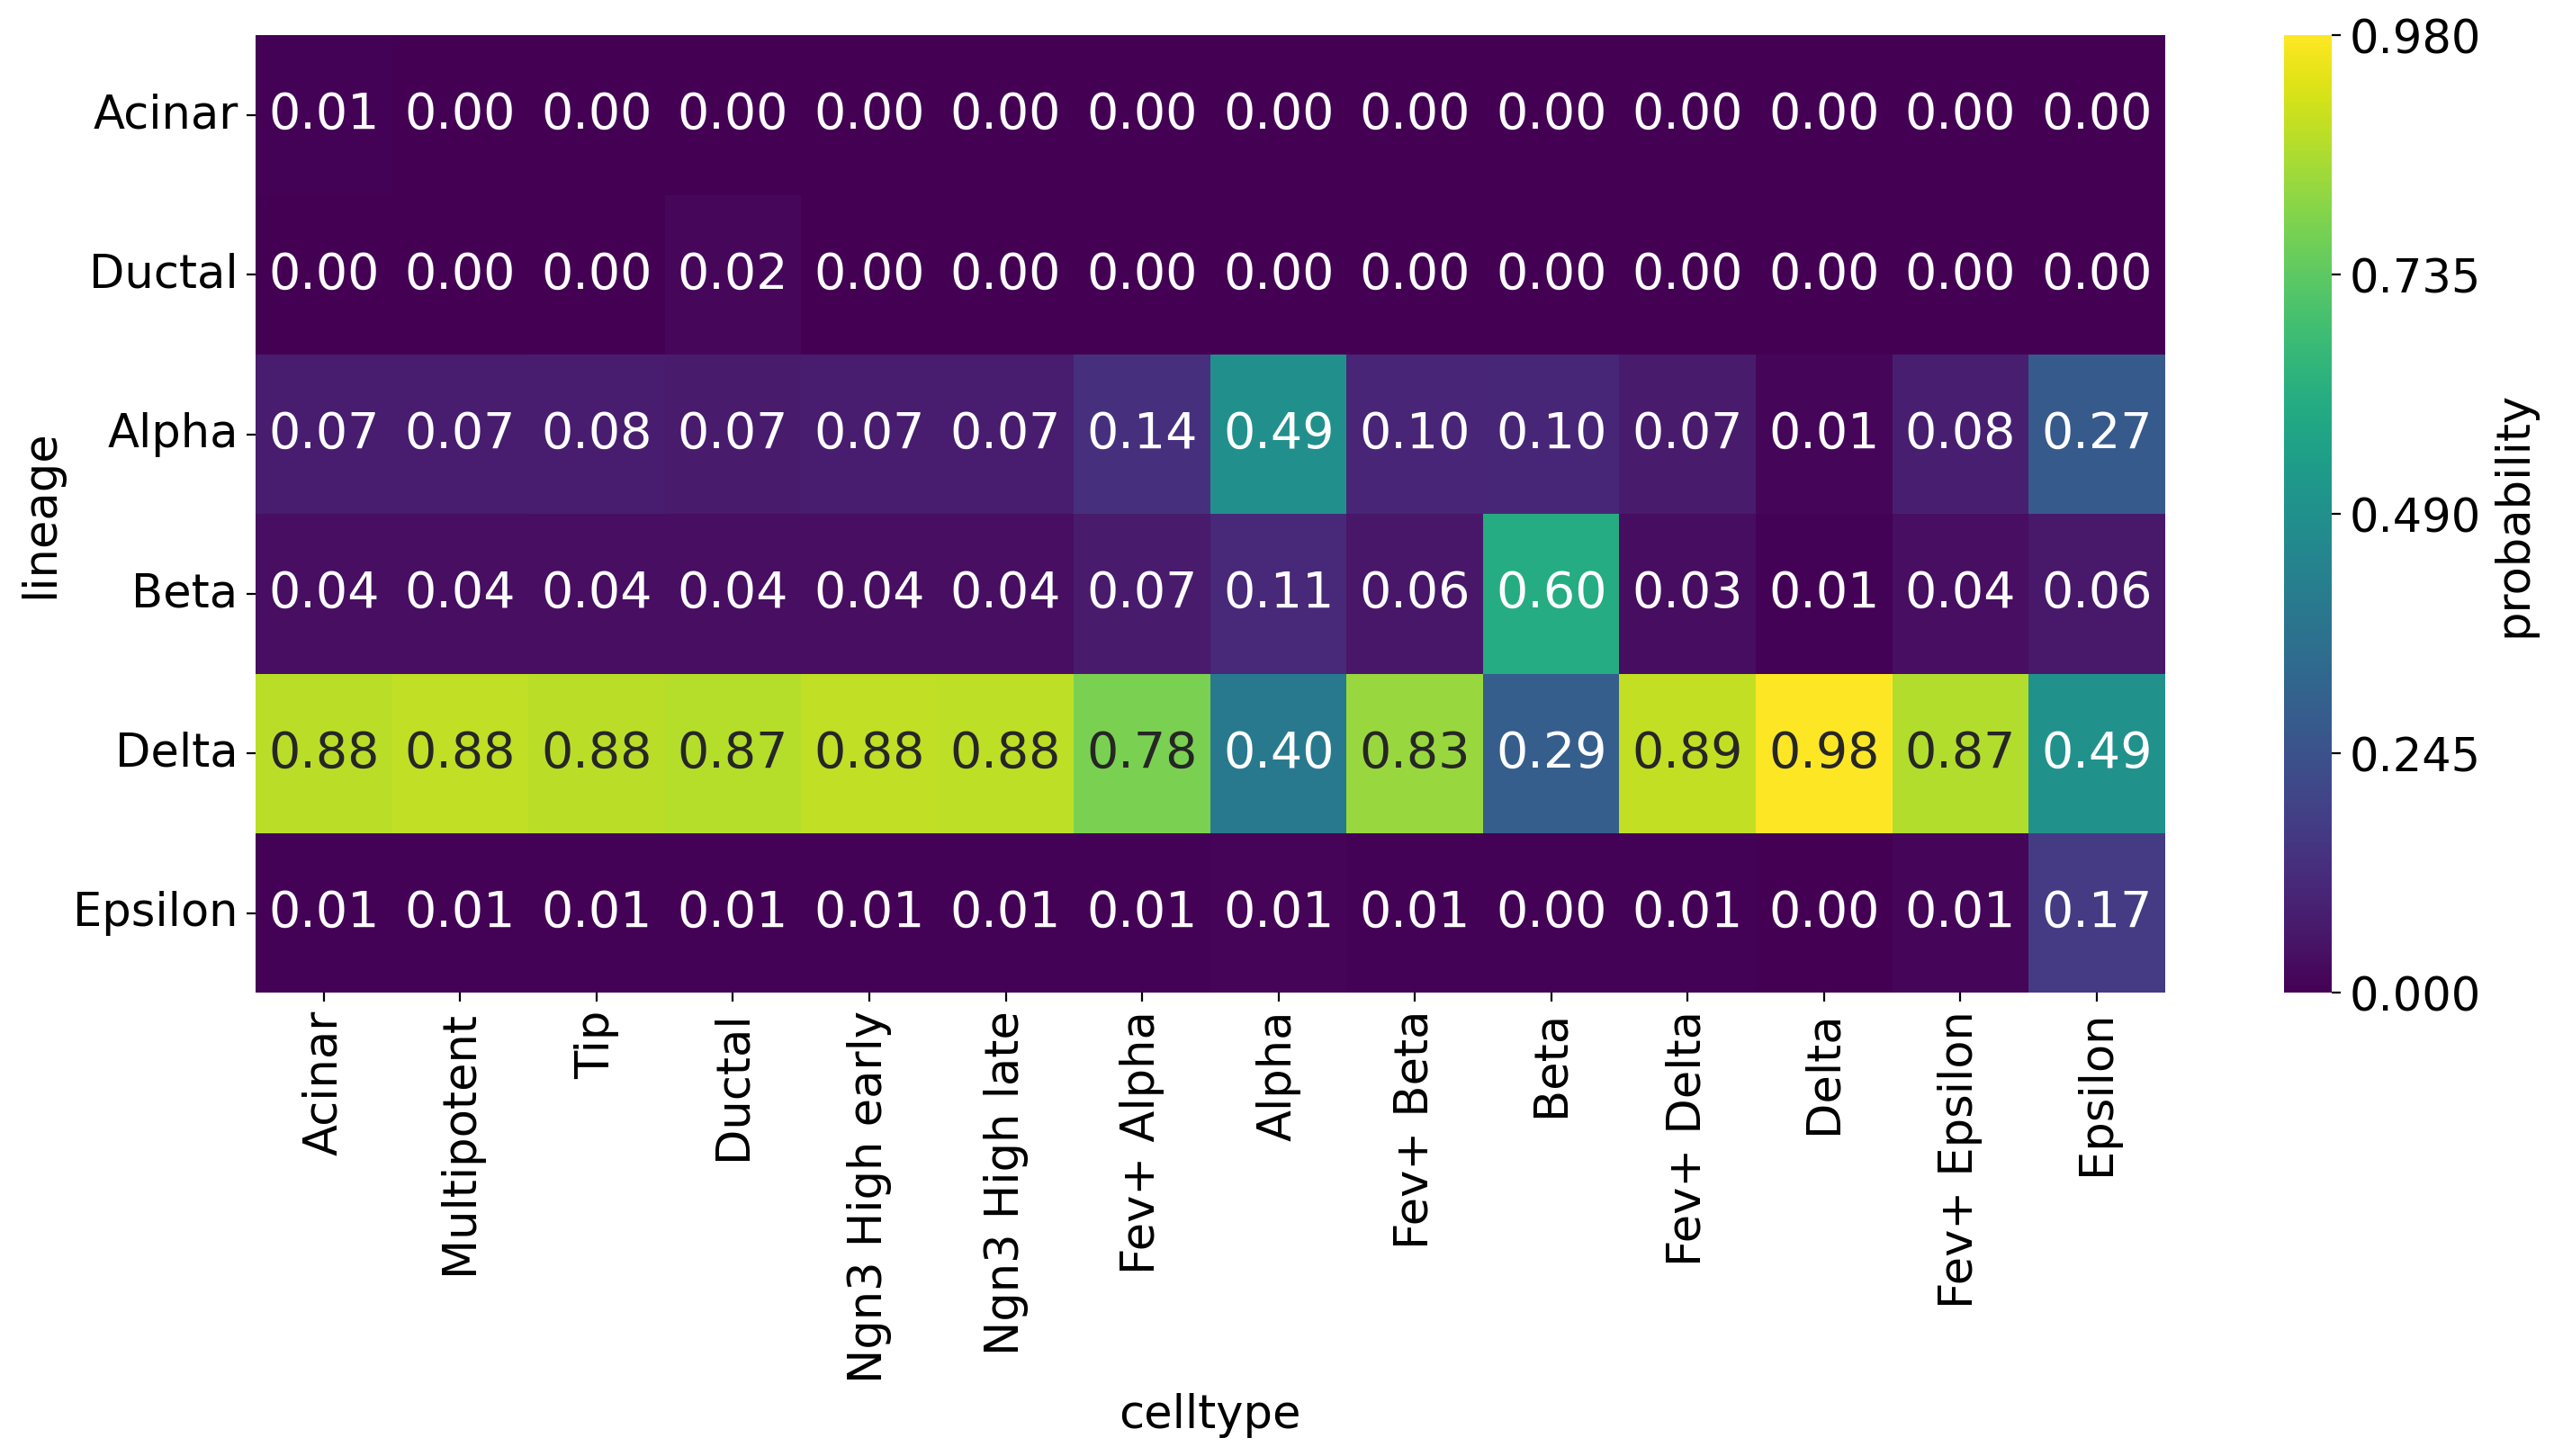

In [13]:
cr.pl.aggregate_absorption_probabilities(
    adata,
    mode='heatmap',
    lineages=["Acinar", "Ductal", "Alpha", "Beta", "Delta", "Epsilon"],
    cluster_key='celltype',
    clusters=['Acinar', 'Multipotent', 'Tip', 'Ductal', 'Ngn3 High early', 'Ngn3 High late', 'Fev+ Alpha', 'Alpha', 'Fev+ Beta', 'Beta', 'Fev+ Delta', 'Delta', 'Fev+ Epsilon', 'Epsilon'],
    figsize=(17, 7),
    title="",
    #save="transprobs_wot.png"
)

In [14]:
cluster = ['Acinar', 'Multipotent', 'Tip', 'Ductal', 'Ngn3 High early', 'Ngn3 High late', 'Fev+ Alpha', 'Alpha', 'Fev+ Beta', 'Beta', 'Fev+ Delta', 'Delta', 'Fev+ Epsilon', 'Epsilon']
terminal_cluster = ["Acinar", "Ductal", "Alpha", "Beta", "Delta", "Epsilon"]

aggregated_absorption_prob = np.empty((len(terminal_cluster), len(cluster)))
data = g.absorption_probabilities.X
sums = np.sum(data, axis=0)
tmp = adata.obs['celltype']

for i in range(len(cluster)):
    aggregated_absorption_prob[:,i] = np.dot(np.array((tmp.array==cluster[i]).astype(int)),data)
for i in range(len(cluster)):
    aggregated_absorption_prob[:,i] = aggregated_absorption_prob[:,i]/np.sum(aggregated_absorption_prob[:,i])
df = pd.DataFrame(aggregated_absorption_prob)
df.index = terminal_cluster
df.columns = cluster

In [15]:
correct_transitions = [('Acinar', 'Acinar'), ('Acinar', 'Tip'), 
                       ('Acinar', 'Multipotent'), ('Ductal', 'Ductal'),
                       ('Ductal', 'Multipotent'), ('Alpha', 'Alpha'), ('Alpha', 'Fev+ Beta'), ('Alpha', 'Fev+ Delta'),
                       ('Alpha', 'Fev+ Alpha'), ('Alpha', 'Fev+ Epsilon'), ('Alpha', 'Ngn3 High early'),
                       ('Alpha', 'Ngn3 High late'), ('Beta', 'Beta'), ('Beta', 'Fev+ Beta'), ('Beta', 'Fev+ Delta'),
                       ('Beta', 'Fev+ Alpha'), ('Beta', 'Fev+ Epsilon'), ('Beta', 'Ngn3 High early'), 
                       ('Beta', 'Ngn3 High late'), ('Delta', 'Delta'), ('Delta', 'Fev+ Beta'), 
                       ('Delta', 'Fev+ Delta'), ('Delta', 'Fev+ Alpha'), ('Delta', 'Fev+ Epsilon'),
                       ('Delta', 'Ngn3 High early'), ('Delta', 'Ngn3 High late'), ('Epsilon', 'Epsilon'), 
                       ('Epsilon', 'Fev+ Beta'), ('Epsilon', 'Fev+ Delta'), ('Epsilon', 'Fev+ Alpha'), 
                       ('Epsilon', 'Fev+ Epsilon'), ('Epsilon', 'Ngn3 High early'), ('Epsilon', 'Ngn3 High late'), 
                       ('Alpha', 'Multipotent'),('Epsilon', 'Multipotent'), ('Beta', 'Multipotent'), 
                       ('Delta', 'Multipotent')]

sum_prob = 0
for i in correct_transitions:
    sum_prob = sum_prob + df.loc[i]
mean_prob = sum_prob/len(cluster)
mean_prob

0.6616601169142842

# Velocity stream plot

computing velocity embedding
    finished (0:00:04) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


<Figure size 600x400 with 0 Axes>

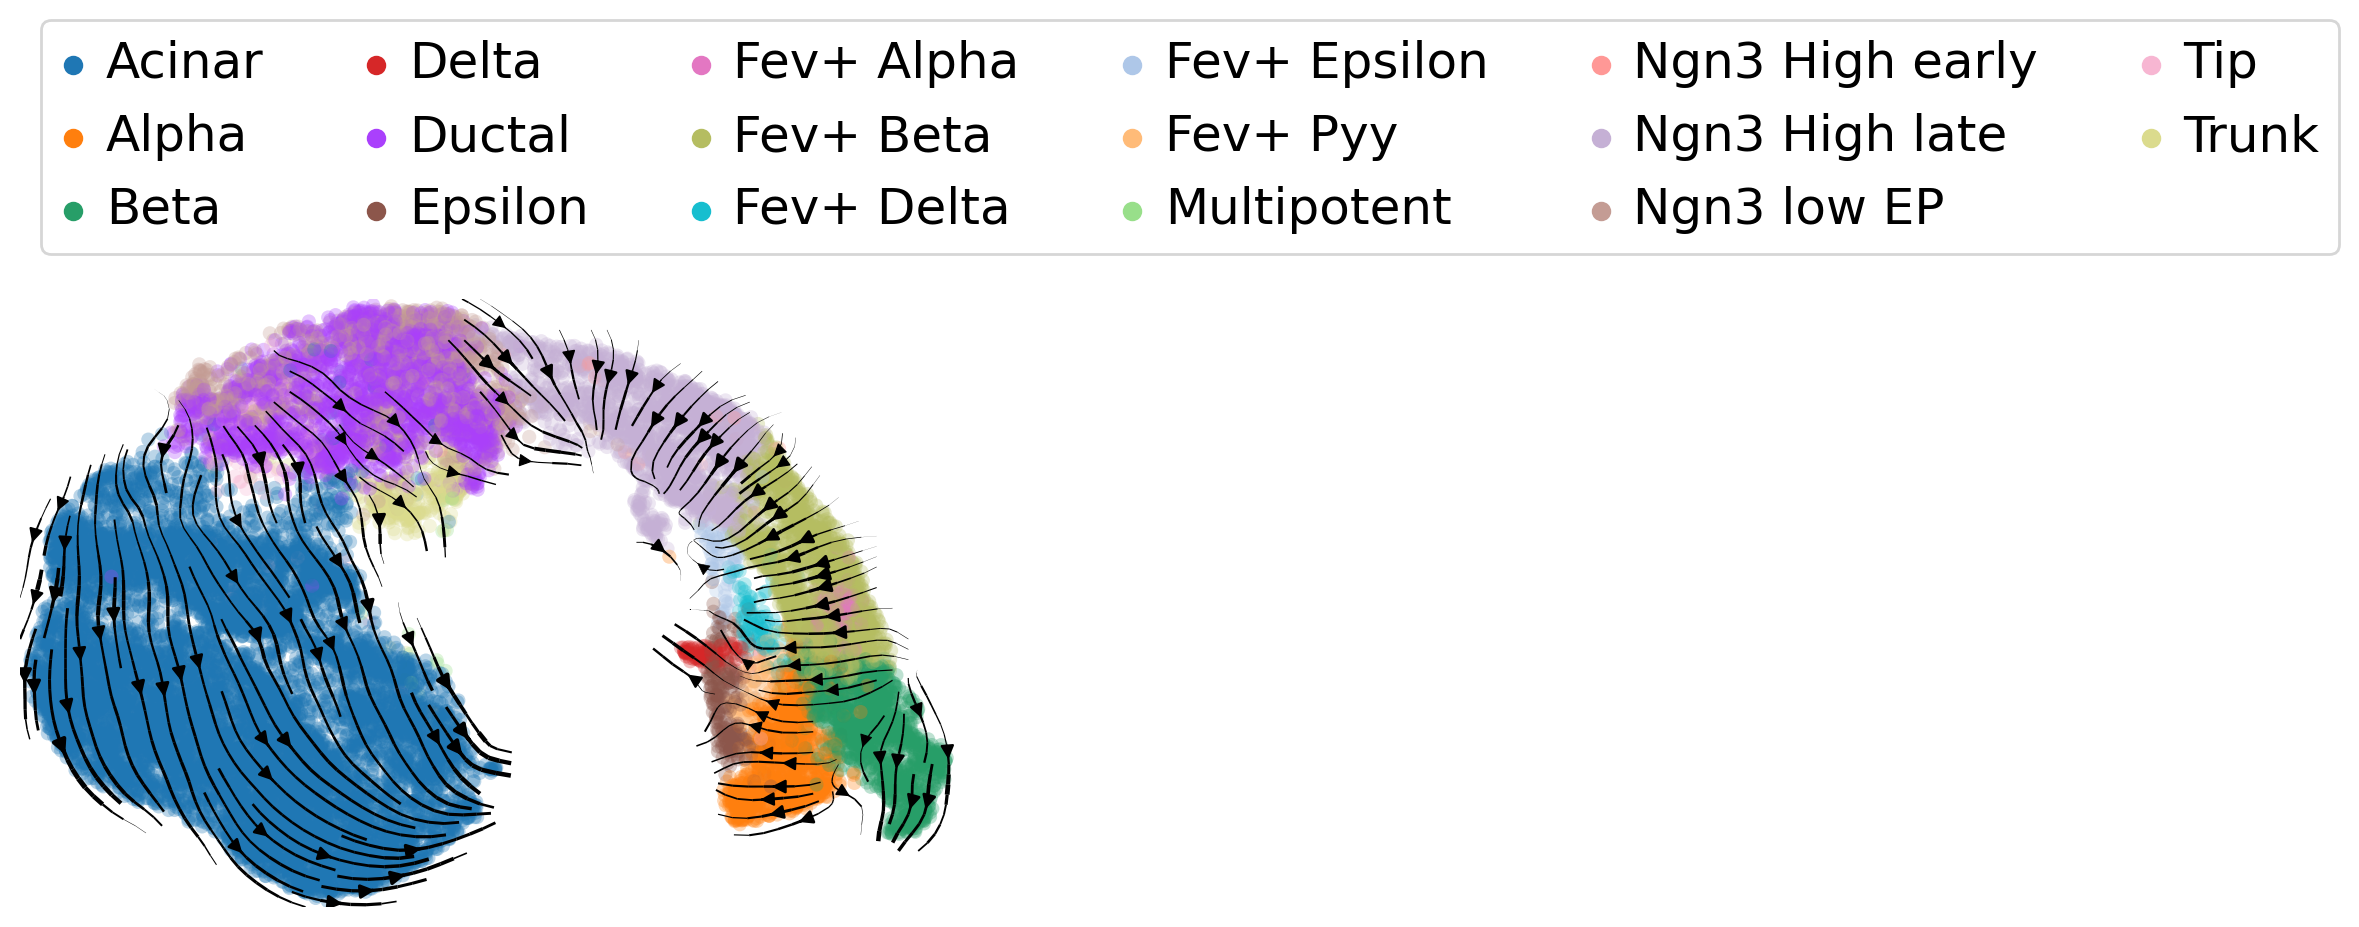

In [16]:
adata.uns["velocity_graph"] = vk.transition_matrix

scv.set_figure_params('scvelo', transparent=True, fontsize=10, dpi_save=400,color_map='viridis')
fig = plt.figure()
ax = scv.pl.velocity_embedding_stream(adata, basis="umap", smooth=0.5, title="", legend_loc="none", show=False, color='celltype')
legend =ax.legend(bbox_to_anchor=[1.25, 1.5], loc='upper center', ncol=6,frameon=True, prop={'size': 18})
#plt.savefig("velstream_pancreas1415_scvelo", dpi=800, bbox_inches='tight')

# Velocity confidence

In [18]:
scv.tl.velocity_confidence(adata)

--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_confidence_transition' (adata.obs)


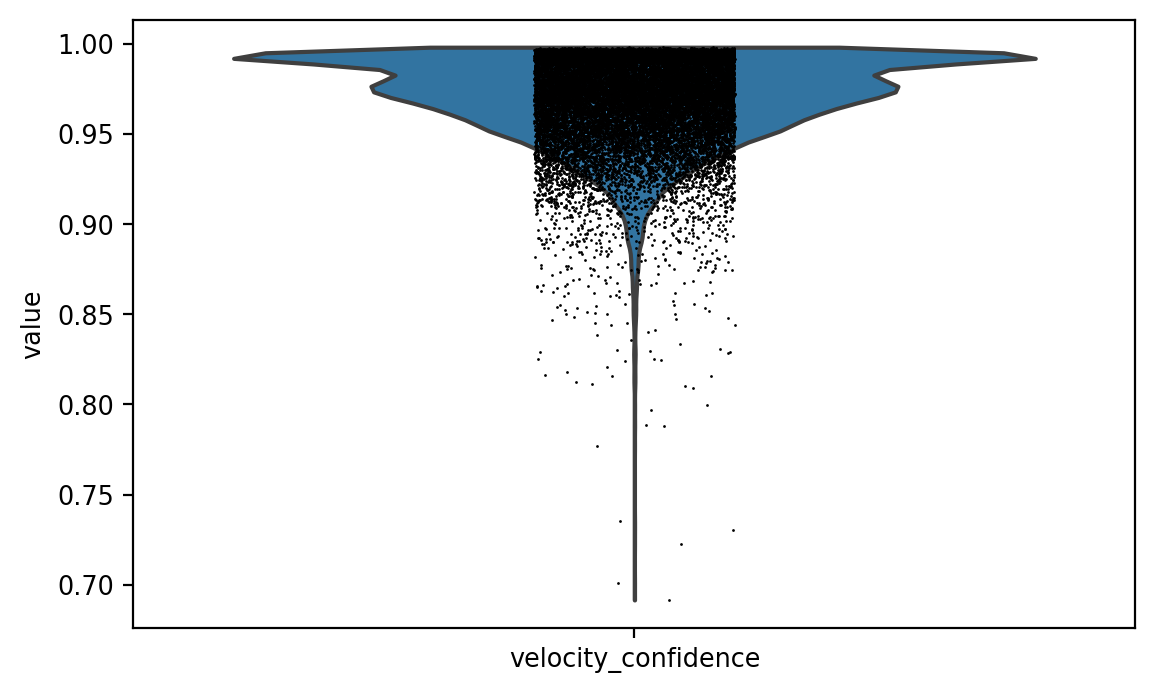

In [19]:
sc.pl.violin(adata, keys='velocity_confidence')

# Umap

/home/icb/jonas.flor/miniconda3/envs/neuralBenchmark_moscot/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


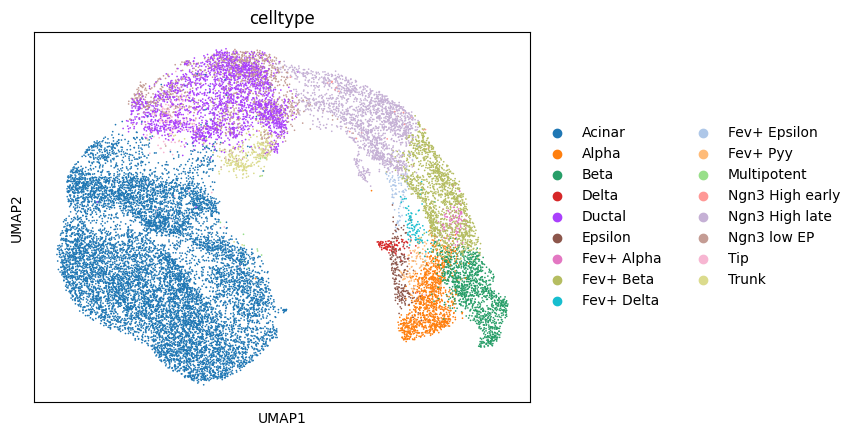

In [7]:
sc.pl.umap(adata, color='celltype')